In [9]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#from scipy.stats import chi2_contingency
from statsmodels.stats.contingency_tables import Table2x2
from statsmodels.stats.multitest import multipletests
from scipy.special import erf
from lifelines import CoxTimeVaryingFitter
import cmdstanpy
from cmdstanpy import CmdStanModel
import arviz as az

from multipathogen_sero import (
    simulate_infections,
    simulate_infections_survivor,
    simulate_infections_discrete,
    simulation_to_regression_df,
    simulation_to_survey_long,
    survey_long_to_wide,
    get_constant_foi,
    get_constant_foi_survivor
)

from multipathogen_sero.config import PROJ_ROOT, STAN_DIR, MODEL_FITS_DIR
# # Prepend to PATH (Windows uses ; as separator)
# current_path = os.environ.get('PATH', '')
# new_path = ';'.join(CMDSTAN_PATHS) + ';' + current_path
# os.environ['PATH'] = new_path


# Simulation

In [76]:
n_people = 10000 #number of individuals n
np.random.seed(42)  # For reproducibility
t_max=100
birth_times = np.random.uniform(0, t_max, size=n_people)  # Random birth times for individuals
n_pathogens=3 #number of pathogens K

pathogen_names = [f'Pathogen {i}' for i in range(1,n_pathogens+1)]  # Names for pathogens
#foi_list = [get_exponential_foi(0, 1) for k, pathogen_name in enumerate(pathogen_names)]

baseline_hazards = [0.1*k for k in range(1,n_pathogens+1)]  # Example baseline hazards
foi_list = [
    get_constant_foi(a=baseline_hazards[k]) for k in range(n_pathogens)
]
survivor_list = [
    get_constant_foi_survivor(a=baseline_hazards[k]) for k in range(n_pathogens)
]

Text(0.5, 0, 'Time')

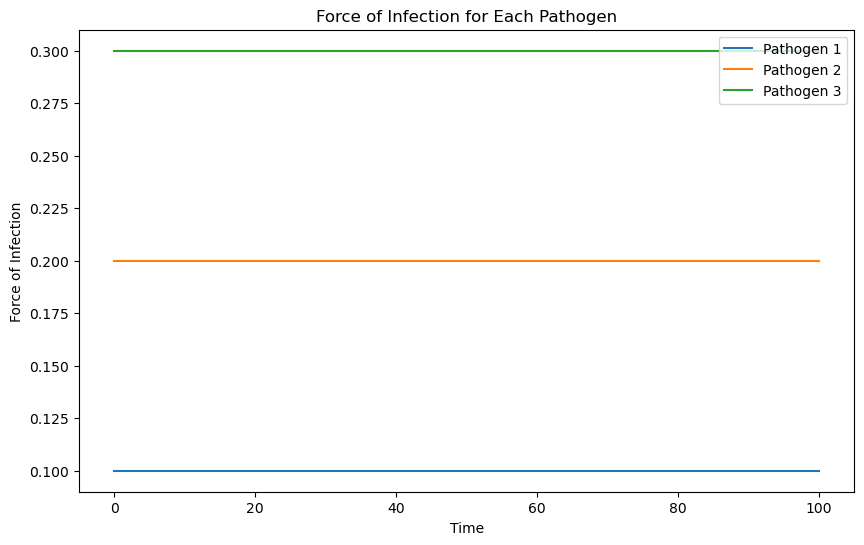

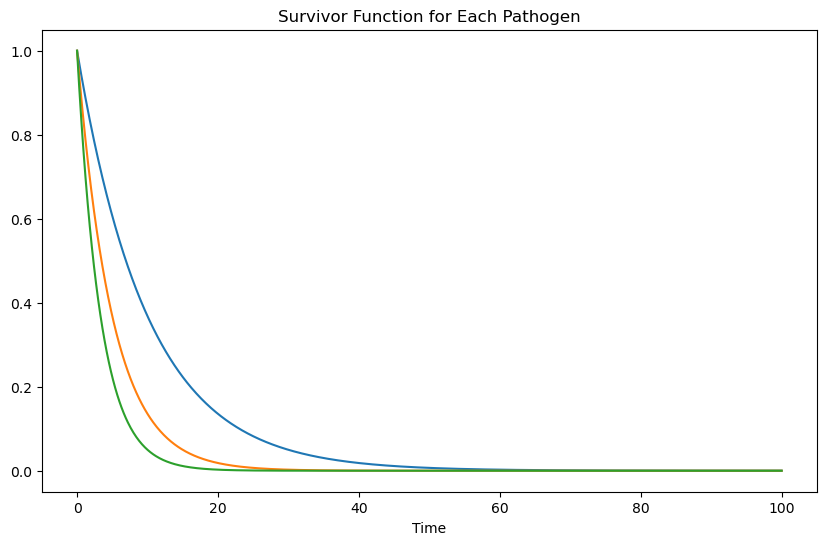

In [77]:
#plot fois
t = np.linspace(0, t_max, 1000)
plt.figure(figsize=(10, 6)) 
for k, foi in enumerate(foi_list):
    plt.plot(t, foi(t), label=pathogen_names[k])
plt.title('Force of Infection for Each Pathogen')
plt.xlabel('Time')
plt.ylabel('Force of Infection')
plt.legend()

#plot survivors
plt.figure(figsize=(10, 6))
for k, survivor in enumerate(survivor_list):
    plt.plot(t, survivor(t), label=pathogen_names[k])
plt.title('Survivor Function for Each Pathogen')
plt.xlabel('Time')

Component 1: [0, 1]
Component 2: [2]


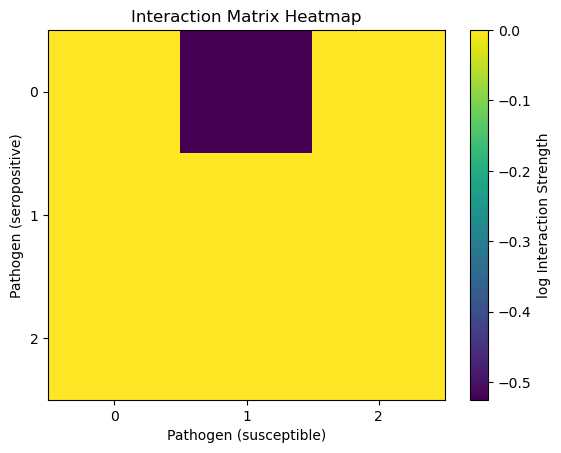

In [78]:
# Interaction matrix

from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

# spike and slab on each coefficient of the interaction matrix
np.random.seed(42)  # For reproducibility
interaction_indicator = np.random.binomial(1, 0.1, size=(n_pathogens, n_pathogens))
interaction_indicator[np.arange(n_pathogens), np.arange(n_pathogens)] = 0
beta_mat = np.random.normal(0, 1, size=(n_pathogens, n_pathogens)) * interaction_indicator
interaction_mat = np.exp(beta_mat)
#plot the interaction matrix as a heatmap
plt.imshow(np.log(interaction_mat), cmap='viridis', aspect='auto')
plt.ylabel('Pathogen (seropositive)')
plt.xlabel('Pathogen (susceptible)')
plt.xticks(ticks=np.arange(n_pathogens), labels=np.arange(0, n_pathogens))
plt.yticks(ticks=np.arange(n_pathogens), labels=np.arange(0, n_pathogens))
plt.colorbar(label='log Interaction Strength')
plt.title('Interaction Matrix Heatmap')

# Convert interaction_indicator to a sparse matrix
adj_matrix = csr_matrix(interaction_indicator)

# Find weakly connected components (ignoring direction)
n_components, labels = connected_components(csgraph=adj_matrix, directed=True, connection='weak')

# Group node indices by component
components = [np.where(labels == i)[0] for i in range(n_components)]

for i, comp in enumerate(components):
    print(f"Component {i+1}: {comp.tolist()}")

In [79]:
start = time.time()
simulate_infections_df = simulate_infections(n_people, n_pathogens, foi_list, interaction_mat, t_max=t_max, birth_times=birth_times, random_seed=42)
print(f"simulate_infections took {time.time() - start:.3f} seconds")


simulate_infections took 0.899 seconds


# Bayesian Cox Regression

In [ ]:
#########################
k_infector = 2       # Infecting pathogen to analyze
n_people_subsample = min(1000, n_people)  # Subsample size for analysis
#########################


regression_df_for_pathogen_k = simulation_to_regression_df(
    simulate_infections_df,
    k_infector=k_infector,  # Set to None to include all pathogens, or specify a specific pathogen index
    t_max=t_max
)
regression_df_for_pathogen_k_subsampled = regression_df_for_pathogen_k[regression_df_for_pathogen_k["individual"]<=n_people_subsample]

In [15]:
stan_data = {
    "N": n_people_subsample, # Number of individuals
    "P": n_pathogens - 1, # Number of covariates
    "n_rows": len(regression_df_for_pathogen_k_subsampled), # Number of observation rows
    "T_L": regression_df_for_pathogen_k_subsampled["start_time"].values,
    "T_R": regression_df_for_pathogen_k_subsampled["stop_time"].values,
    "event": regression_df_for_pathogen_k_subsampled["event"].values,
    "person_id": regression_df_for_pathogen_k_subsampled["individual"].values,
    "X": regression_df_for_pathogen_k_subsampled.filter(like='serostatus_').values, # get the data for columns starting with serostatus_,
    "beta_prior_setting": 2, # 0 for no prior, 1 for Laplace prior, 2 for spike and slab prior
    "laplace_scale": 1.0,  # scale for Laplace prior when beta_prior_setting == 1
    "slab_scale": 1.0,  # Scale for the slab in spike and slab prior
    "spike_scale": 0.05,  # Scale for the spike in spike and slab prior
    "pi": 0.1 # Inclusion probability for the spike and slab prior
}

In [17]:
model = CmdStanModel(
    stan_file= STAN_DIR / "infection_histories.stan"
)

fit = model.sample(
    data=stan_data,
    chains=4,
    iter_sampling=500,
    iter_warmup=500,
    parallel_chains=4,
    seed=123
)

12:06:49 - cmdstanpy - INFO - compiling stan file /home/ayan/sero/multipathogen-sero/multipathogen_sero/stan/infection_histories.stan to exe file /home/ayan/sero/multipathogen-sero/multipathogen_sero/stan/infection_histories
12:07:03 - cmdstanpy - INFO - compiled model executable: /home/ayan/sero/multipathogen-sero/multipathogen_sero/stan/infection_histories
12:07:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:07:04 - cmdstanpy - INFO - CmdStan done processing.


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

Rank-normalized split R-hat values satisfactory for all parameters.

Processing complete, no problems detected.

                       Mean      MCSE    StdDev       MAD          5%  \
lp__            -298.458000  0.064345  2.230750  1.795430 -302.867000   
baseline_hazard    0.072826  0.000223  0.010496  0.009933    0.055704   
beta_raw[1]        0.033343  0.004636  0.108463  0.051853   -0.067082   
beta_raw[2]        0.020789  0.001754  0.077603  0.051086   -0.069458   
beta_raw[3]        0.003274  0.000757  0.056919  0.049531   -0.079532   
...                     ...       ...       ...       ...         ...   
log_lik[96]       -2.677700  0.003273  0.142237  0.1

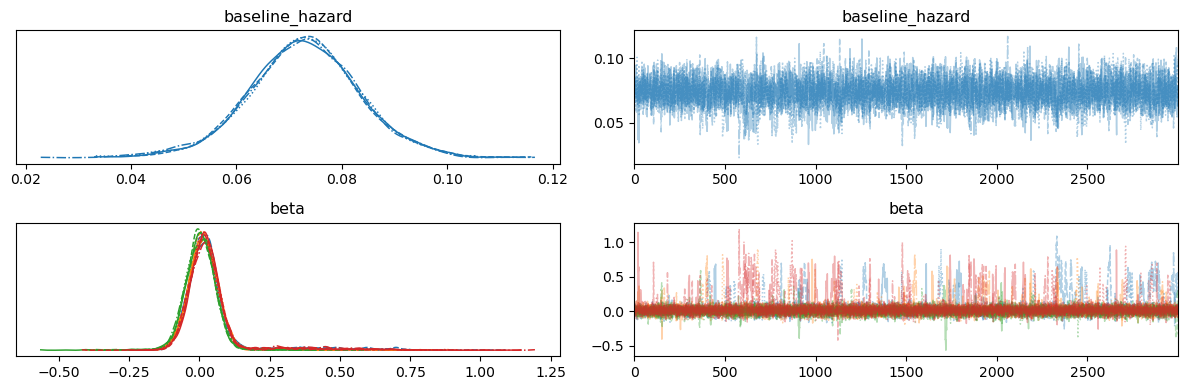

In [18]:
# Print summary
print(fit.diagnose())
print(fit.summary())

# Check R-hat and ESS
df_summary = fit.summary()
print("Any R-hat > 1.01?", (df_summary["R_hat"] > 1.01).any())
print("Any ESS < 400?", (df_summary["ESS_bulk"] < 400).any())

# Optional: convert to ArviZ for easier plotting
idata = az.from_cmdstanpy(posterior=fit)

# Plot trace plots
az.plot_trace(idata, var_names=["baseline_hazard", "beta"])
plt.tight_layout()
plt.show()

True baseline hazard: 0.08


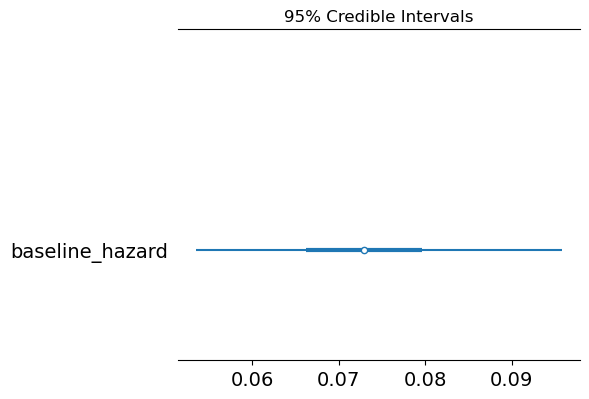

True beta coefficients: [ 0.59772047 -0.16175539 -0.          0.        ]


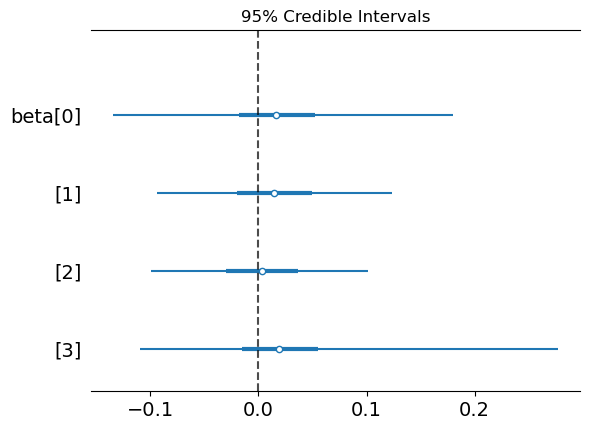

In [19]:
print(f"True baseline hazard: {baseline_hazards[k_infector-1]}")
az.plot_forest(idata, var_names=["baseline_hazard"], 
               hdi_prob=0.95, combined=True)
plt.title("95% Credible Intervals")
plt.tight_layout()
plt.show()

print(f"True beta coefficients: {np.concatenate([beta_mat[:k_infector-1, k_infector-1],beta_mat[k_infector:, k_infector-1]])}")

ax = az.plot_forest(idata, var_names=["beta"], 
                    hdi_prob=0.95, combined=True)
plt.axvline(0, color='black', linestyle='--', alpha=0.7)
plt.title("95% Credible Intervals")
plt.tight_layout()
plt.show()

In [20]:
idata = az.from_cmdstanpy(posterior=fit)
# Now you can calculate WAIC and LOO
waic = az.waic(idata)
loo = az.loo(idata)

print(waic)
print(loo)

Computed from 12000 posterior samples and 100 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -304.44    11.87
p_waic        1.49        -
Computed from 12000 posterior samples and 100 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -304.45    11.87
p_loo        1.50        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      100  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



# serological data

In [80]:
survey_every = 1.0
survey_times = {
    i+1: np.insert(
        survey_every * np.arange(np.floor(birth_times[i]/survey_every)+1, np.floor(t_max/survey_every)+1),
        0, birth_times[i]
    )
    for i in range(n_people)
}

def get_survey_bounds(row):
    times = survey_times[row["individual"]]
    i = np.searchsorted(times, row["time"], side="left")
    if i == len(times):
        raise NotImplementedError(f"No next survey time ≥ {row['time']} for individual {row['individual']}")
    if i == 0:
        raise NotImplementedError(f"No last survey time < {row['time']} for individual {row['individual']}")
    next_time = times[i]
    last_time = times[i - 1]
    return pd.Series({"last_survey_time": last_time, "next_survey_time": next_time})

# infections
infection_intervals = simulate_infections_df.query("event == 'seroconversion'").copy()
infection_intervals["pathogen"] = infection_intervals["pathogen"].astype(int)
infection_intervals[["last_survey_time", "next_survey_time"]] = infection_intervals.apply(get_survey_bounds, axis=1)
last_survey_times = infection_intervals["last_survey_time"].values
next_survey_times = infection_intervals["next_survey_time"].values
infection_person_ids = infection_intervals["individual"].values
infection_pathogen_ids = infection_intervals["pathogen"].values

# lookup
gets_infected = np.zeros((n_people, n_pathogens), dtype=bool)
lookup_indices = np.zeros((n_people, n_pathogens), dtype=int)
for counter, row in enumerate(infection_intervals.itertuples()):
    gets_infected[row.individual - 1, row.pathogen - 1] = True
    lookup_indices[row.individual - 1, row.pathogen - 1] = counter+1 #1-indexed
num_infections = gets_infected.sum()

# noninfections
num_noninfections = n_people * n_pathogens - num_infections
indices = np.argwhere(gets_infected == 0)
lookup_indices[gets_infected == 0] = np.arange(1, num_noninfections + 1) #1-indexed
noninfection_person_ids = indices[:, 0] + 1  # Convert to 1-based indexing
noninfection_pathogen_ids = indices[:, 1] + 1  # Convert to 1-based indexing
censoring_times = np.array([survey_times[i][-1] for i in noninfection_person_ids])


In [ ]:
"""
data {
    int<lower=1> N;                         // Number of individuals
    array[N] real birth_times;               // Birth time for each individual
    int<lower=1> K;                         // Number of pathogens
    array[N,K] int<lower=0, upper=1> gets_infected; // 0 = always negative, 1 = seroconverter
    int<lower=0> num_infections; // Number of infection times (seroconversions)
    int<lower=0> num_noninfections; // Number of uninfected individuals (seronegative)
    array[N,K] int<lower=1, upper=N*K> lookup_indices; // Index to look up individual, pathogen infection times in their respective (1-indexed) arrays
    array[num_infections] real lower_bound_times; // Lower bound of seroconversion time
    array[num_infections] real upper_bound_times; // Upper bound of seroconversion time
    array[num_infections] int<lower=1, upper=N> infection_person_ids; // Individual ID for each seroconversion (should be 1-indexed)
    array[num_infections] int<lower=1, upper=K> infection_pathogen_ids; // Pathogen ID for each seroconversion (should be 1-indexed)
    array[num_noninfections] real censoring_times; // Lower bound of seroconversion time
    array[num_noninfections] int<lower=1, upper=N> noninfection_person_ids; // Individual ID for each seronegative individual (should be 1-indexed)
    array[num_noninfections] int<lower=1, upper=K> noninfection_pathogen_ids; // Pathogen ID for each seronegative individual (should be 1-indexed)
    real <lower=0> time_to_immunity; // timescale for immunity to kick in
                                     // not scientific, just to make the likelihood continuous wrt latent infection times 
    real <lower=0> beta_scale; // scale for Laplace prior on log hazard ratios
}
"""
# TODO: write tests
stan_data = {
    "N": n_people,
    "K": n_pathogens,
    "gets_infected": gets_infected,
    "num_infections": num_infections,
    "num_noninfections": num_noninfections,
    "lookup_indices": lookup_indices,
    "lower_bound_times": last_survey_times,
    "upper_bound_times": next_survey_times,
    "infection_person_ids": infection_person_ids,
    "infection_pathogen_ids": infection_pathogen_ids,
    "censoring_times": censoring_times,
    "noninfection_person_ids": noninfection_person_ids,
    "noninfection_pathogen_ids": noninfection_pathogen_ids,
    "time_to_immunity": 0.05,  # timescale for immunity to kick in
    "beta_scale": 1.0,  # scale for Laplace prior on log hazard ratios
}

print(birth_times[0])
print(gets_infected[0])
print(lookup_indices[0])
print(last_survey_times[lookup_indices[0][gets_infected[0]]-1])
print(next_survey_times[lookup_indices[0][gets_infected[0]]-1])
print(infection_person_ids[lookup_indices[0][gets_infected[0]]-1])
print(infection_pathogen_ids[lookup_indices[0][gets_infected[0]]-1])
print(censoring_times[lookup_indices[0][~gets_infected[0]]-1])
print(noninfection_person_ids[lookup_indices[0][~gets_infected[0]]-1])
print(noninfection_pathogen_ids[lookup_indices[0][~gets_infected[0]]-1])

NameError: name 'n_people' is not defined

In [70]:
model = CmdStanModel(
    stan_file= STAN_DIR / "multiplex_serology.stan"
)

In [82]:
chains = 4
iter_sampling = 200
iter_warmup = 50
parallel_chains = 4
seed = 123
max_treedepth = 20
fit = model.sample(
    data=stan_data,
    chains=chains,
    iter_sampling=iter_sampling,
    iter_warmup=iter_warmup,
    parallel_chains=parallel_chains,
    seed=seed,
    max_treedepth=max_treedepth,
    show_progress=True,
    show_console=False
)

14:28:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:47:04 - cmdstanpy - ERROR - Chain [3] error: terminated by signal 2 Unknown error -2
14:47:04 - cmdstanpy - ERROR - Chain [1] error: terminated by signal 2 Unknown error -2
14:47:04 - cmdstanpy - ERROR - Chain [4] error: terminated by signal 2 Unknown error -2
14:47:04 - cmdstanpy - ERROR - Chain [2] error: terminated by signal 2 Unknown error -2


KeyboardInterrupt: 

In [ ]:
import pickle
import time
name = f"fit_{int(time.time())}"

fit.save_csvfiles(
    MODEL_FITS_DIR / name
)
fit_metadata = {
    "data": {
        "n_people": n_people,
        "n_pathogens": n_pathogens,
        "baseline_hazards": baseline_hazards,
        "survey_every": survey_every,
        "t_max": t_max,
    },
    "model": "multiplex_serology",
    "model_params": {
        "chains": chains,
        "iter_sampling": iter_sampling,
        "iter_warmup": iter_warmup,
        "seed": seed,
        "max_treedepth": max_treedepth
    },
    "notes": "max tree depth 20 okay"
}
with open(PROJ_ROOT / "model_fits" / name / "metadata.pkl", "wb") as f:
    pickle.dump(fit_metadata, f)

In [ ]:
with open(PROJ_ROOT / "model_fits" / name / "metadata.pkl", "rb") as f:
    fit_metadata_read = pickle.load(f)
fit_metadata_read

{'model': 'multiplex_serology',
 'n_people': 100,
 'n_pathogens': 5,
 'baseline_hazards': [0.04, 0.08, 0.12, 0.16, 0.2],
 'survey_every': 10.0,
 't_max': 100,
 'notes': 'all max tree depth'}

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

The following parameters had rank-normalized split R-hat greater than 1.01:
  infection_times[36], infection_times[502], infection_times[919], infection_times[1017], infection_times[1131], infection_times[1231], infection_times[1897], infection_times[1902], infection_times[1940], infection_times[1944], infection_times[2403], infection_times[2463], infection_times[2494], infection_times[2634], infection_times[2652], infection_times[2655], infection_times[2670], infection_times[2979], infection_times[3085], infection_times[3191], infection_times[3241], infection_times[3335], infection_times[3383], infection_times[3459], infection_times[3467], infection_times[3566], infe

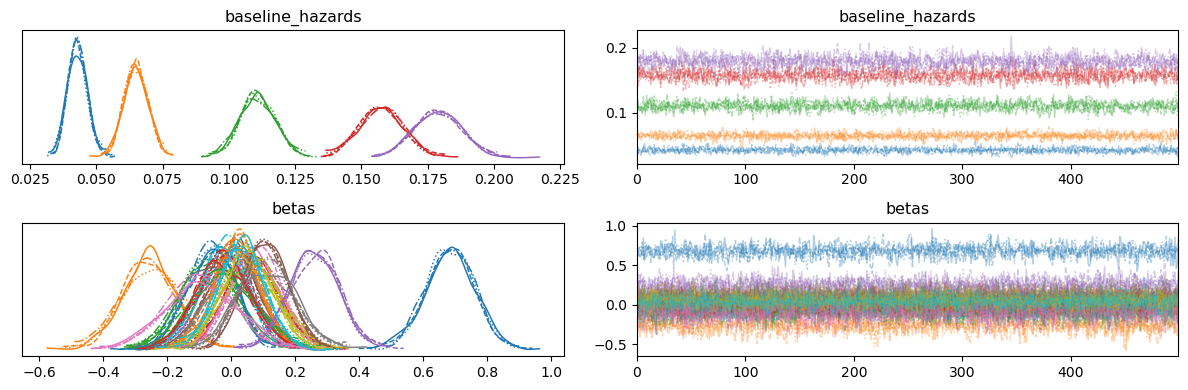

In [73]:
# Print summary
print(fit.diagnose())
print(fit.summary())

# Check R-hat and ESS
df_summary = fit.summary()
print("Any R-hat > 1.01?", (df_summary["R_hat"] > 1.01).any())
print("Any ESS < 400?", (df_summary["ESS_bulk"] < 400).any())

# Optional: convert to ArviZ for easier plotting
idata = az.from_cmdstanpy(posterior=fit)

# Plot trace plots
az.plot_trace(idata, var_names=["baseline_hazards", "betas"])
plt.tight_layout()
plt.show()

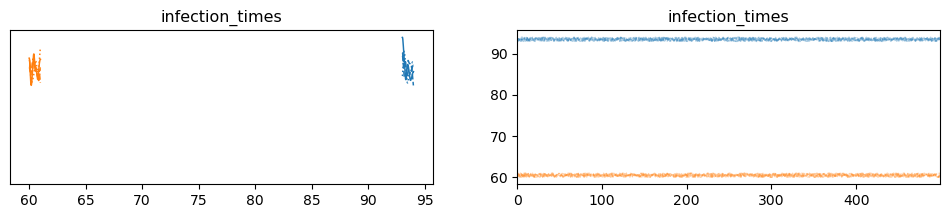

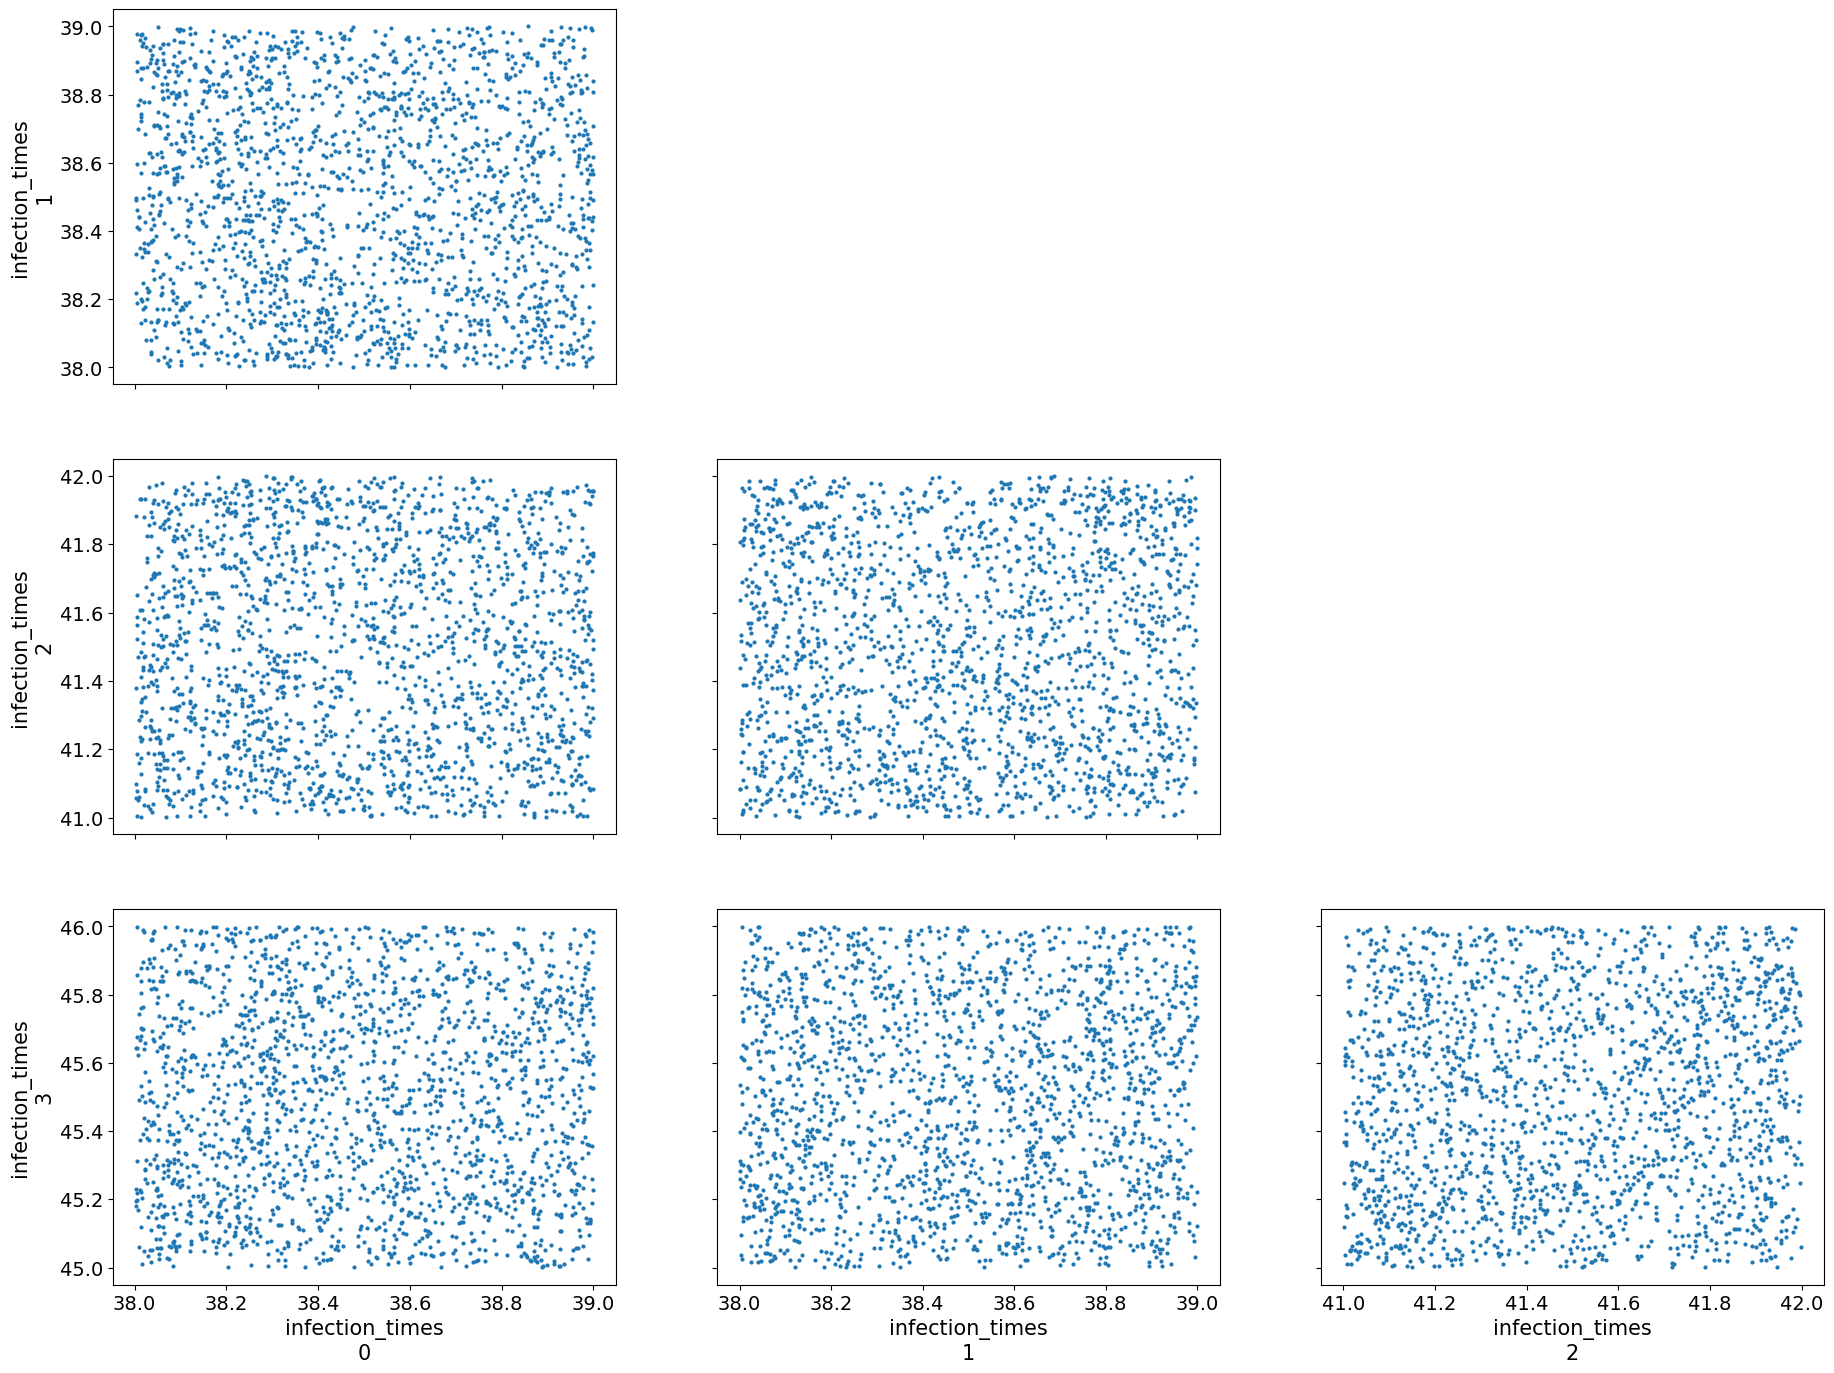

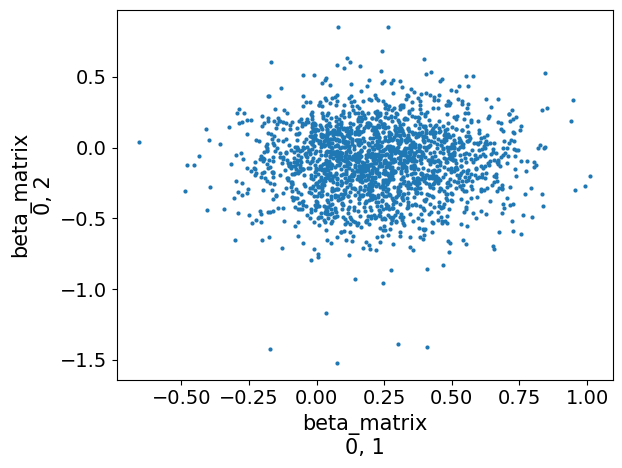

In [61]:
#more diagnostics
az.plot_trace(idata, var_names = "infection_times", coords= {"infection_times_dim_0": [10,11]})
plt.show()
az.plot_pair(
    idata,
    var_names=["infection_times"],
    coords={"infection_times_dim_0": [0, 1, 2, 3]},
    kind="scatter"
)
plt.show()
az.plot_pair(
    idata,
    var_names=["beta_matrix"],
    coords={"beta_matrix_dim_0": [0], "beta_matrix_dim_1": [1, 2]},
    kind="scatter"
)
plt.show()


True baseline hazards: [0.04, 0.08, 0.12, 0.16, 0.2]


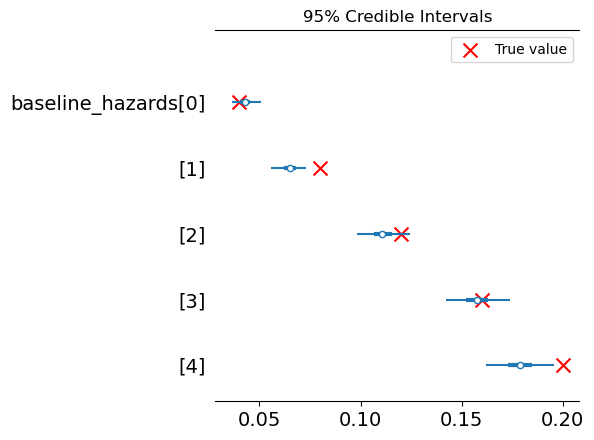

True beta coefficients: [[-0.          0.59772047  0.          0.          0.        ]
 [-0.         -0.          0.          0.         -0.        ]
 [-0.         -0.16175539 -0.         -0.         -0.        ]
 [ 0.         -0.          0.          0.          0.        ]
 [ 0.          0.         -0.         -0.          0.        ]]


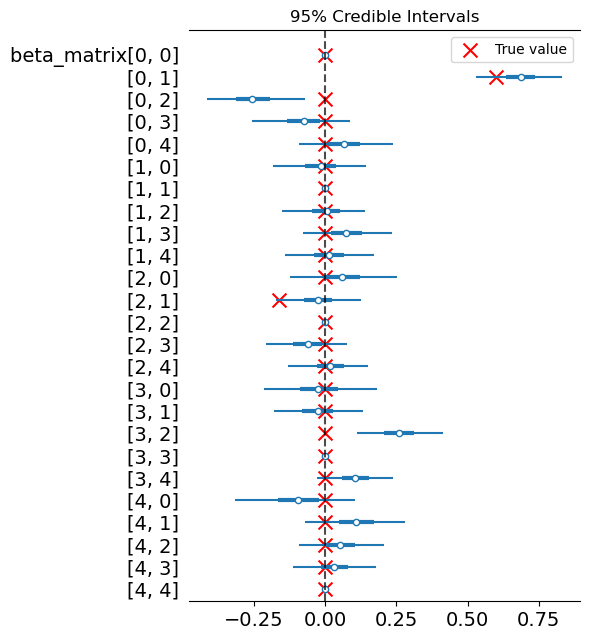

In [74]:
print(f"True baseline hazards: {baseline_hazards}")
axes = az.plot_forest(idata, var_names=["baseline_hazards"], 
                      hdi_prob=0.95, combined=True)
ax = axes[0] if isinstance(axes, (list, np.ndarray)) else axes
yticks = ax.get_yticks()
for i, val in enumerate(baseline_hazards[::-1]):
    ax.scatter(val, yticks[i], marker='x', color='red', s=100, label='True value' if i == 0 else "")
if len(baseline_hazards) > 0:
    ax.legend(loc='best')
plt.title("95% Credible Intervals")
plt.tight_layout()
plt.show()

print(f"True beta coefficients: {beta_mat}")
axes = az.plot_forest(idata, var_names=["beta_matrix"], 
                      hdi_prob=0.95, combined=True)
ax = axes[0] if isinstance(axes, (list, np.ndarray)) else axes
plt.axvline(0, color='black', linestyle='--', alpha=0.7)
yticks = ax.get_yticks()
for i, val in enumerate(beta_mat.flatten()[::-1]):
    ax.scatter(val, yticks[i], marker='x', color='red', s=100, label='True value' if i == 0 else "")
if beta_mat.size > 0:
    ax.legend(loc='best')
plt.title("95% Credible Intervals")
plt.tight_layout()
plt.show()

In [75]:
idata = az.from_cmdstanpy(posterior=fit)
# Now you can calculate WAIC and LOO
waic = az.waic(idata)
loo = az.loo(idata)

print(waic)
print(loo)

Computed from 2000 posterior samples and 1000 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -14251.67   119.40
p_waic       37.12        -
Computed from 2000 posterior samples and 1000 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -14251.69   119.40
p_loo       37.15        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     1000  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

